In [112]:
import numpy as np
from pylibxc import LibXCFunctional
import fragments
from pyscf import gto, dft, scf,df
import time

In [113]:
def D2n(D, *phis):
    ngrid = len(phis)
    n = 0.
    for phi in phis:
        n += np.einsum("pu,pv,uv->p", phi, phi, D, optimize=True)
    n /= ngrid
    return n

In [159]:
separation = 1.39
geo = gto.M(atom=[
    ['H', (-separation/2, 0.0, 0.0)],
    ['H', (separation/2, 0., 0.)],
],
unit='bohr', basis='aug-cc-pv5z', verbose=0)
# 
rgeo = gto.M(atom=[
    ['ghost-H', (-separation/2, 0.0, 0.0)],
    ['H', (separation/2, 0., 0.)],
],
unit='bohr', basis='aug-cc-pv5z', spin=1, verbose=0)
rdft = fragments.FragmentDFT(rgeo,'pbe')
# 
lgeo = gto.M(atom=[
    ['H', (-separation/2, 0.0, 0.0)],
    ['ghost-H', (separation/2, 0., 0.)],
],
unit='bohr', basis='aug-cc-pv5z', spin=1,verbose=0)
ldft = fragments.FragmentDFT(lgeo,'pbe')




In [160]:
print(geo.nelec)
print(geo.spin)
print(rgeo.nelec)
print(lgeo.nelec)



(1, 1)
0
(1, 0)
(1, 0)


In [116]:
mydft = dft.UKS(geo).density_fit(auxbasis="cc-pVDZ-JKFIT")
mydft.xc='pbe'
mydft.kernel()

-1.1665938734013492

In [117]:
# some ao matrices
S = geo.intor("int1e_ovlp")
Vext = geo.intor("int1e_nuc")
T = geo.intor("int1e_kin")
I = geo.intor("int2e")

In [118]:
mydft.with_df._cderi_to_save = 'saved_cderi.h5'
mydft.kernel()

-1.1665938734013475

In [119]:
mydf = df.DF(geo)
mydf.auxbasis = df.make_auxbasis(geo)
mydf._cderi_to_save = 'saved_cderi.h5'
mydf.build()

In [120]:
#generate CDERI
cderi = df.incore.cholesky_eri(geo, auxbasis='weigend')
df.outcore.cholesky_eri(geo, 'saved_cderi.h5', dataname='j3c',
                        auxbasis=df.make_auxbasis(geo))

'saved_cderi.h5'

In [121]:
auxbasis = 'ccpvdz-jk-fit'
auxmol = df.addons.make_auxmol(geo, auxbasis)

# ints_3c is the 3-center integral tensor (ij|P), where i and j are the
# indices of AO basis and P is the auxiliary basis
#ints_3c2e 
ERI_Quv_DF= df.incore.aux_e2(geo, auxmol, intor='int3c2e').T
#ints_2c2e 
ERI_PQ_DF= auxmol.intor('int2c2e')
print(ERI_Quv_DF.shape)
print(ERI_PQ_DF.shape)
print(Dfa.shape)

(46, 160, 160)
(46, 46)
(160, 160)


In [122]:
# define the fragment ensembles
l = fragments.ens([ldft, ], [(0.5, 0.5), ])#same as l = fragments.ens([ldft_spinup, ldft_spindown], [0.5, 0.5 ])
r = fragments.ens([rdft, ], [(0.5, 0.5), ])  # Same for the right fragment

l.get_nelec()
r.get_nelec()


([(1, 0)], [(0, 1)])

In [123]:
# initial run
l.scf(None)
r.scf(None)

In [124]:
# Build an integration grid for the molecule.
grids = dft.gen_grid.Grids(geo) # NOTE: no need to spparate grid and basis use to symmtrical basis and geo.
grids.level = 7  # You can adjust the grid level for higher accuracy if needed.
grids.build()
coords = grids.coords  # Grid points (shape: [npoints, 3])
w = grids.weights
# Evaluate the AO basis functions on the grid.
# This gives an array of AO values at each grid point.
ao_values = dft.numint.eval_ao(geo, coords, deriv=1)
phi, phi_x, phi_y, phi_z = ao_values



In [125]:
Dal = l.get_D()[0]+l.get_D()[1]
Dar = r.get_D()[0]+r.get_D()[1]
print(np.sum(S*Dal))
print(np.sum(S*Dar))
assert np.isclose(np.sum(S*Dal), 1)
assert np.isclose(np.sum(S*Dar), 1)

1.0000000000000002
0.9999999999999998


In [126]:
nl = D2n(Dal, phi)
#assert np.isclose(np.sum(nl*w), 1, atol=1e-7), np.sum(nl*w)

In [127]:
n = D2n(Dar+Dal, phi)
assert np.isclose(np.sum(n*w), 2, atol=1e-7), np.sum(n*w)

In [128]:
def Ts_libxc(func_id, Da, Db, ao_values, w):
    """
    TODO: this can be modified to calculate both Ts and Exc.
    """
    Ts = 0.0

    func = LibXCFunctional(func_id, 2)  # TODO: now treats everything spin-unpolarized
    #assert func.get_kind() == 3, "%d is not a kinetic functional" % func_id

    if func.get_family() == 1: # LDA
        order = 0
        phi = ao_values
    elif func.get_family() == 2:  # GGA
        order = 1
        phi, phi_x, phi_y, phi_z = ao_values
    else:
        raise ValueError("META-GGA not done.")
    
    inp = {}
    rhoa = D2n(Da, phi)
    rhob = D2n(Db, phi)
    inp["rho"] = np.array(np.vstack((rhoa, rhob)).T, order="C")
    
    if order >= 1:
        rhoa_x = 2.0 * np.einsum('pm,mn,pn->p', phi, Da, phi_x, optimize=True)
        rhoa_y = 2.0 * np.einsum('pm,mn,pn->p', phi, Da, phi_y, optimize=True)
        rhoa_z = 2.0 * np.einsum('pm,mn,pn->p', phi, Da, phi_z, optimize=True)
        gamma_a = rhoa_x ** 2 + rhoa_y ** 2 + rhoa_z ** 2
        rhob_x = 2.0 * np.einsum('pm,mn,pn->p', phi, Db, phi_x, optimize=True)
        rhob_y = 2.0 * np.einsum('pm,mn,pn->p', phi, Db, phi_y, optimize=True)
        rhob_z = 2.0 * np.einsum('pm,mn,pn->p', phi, Db, phi_z, optimize=True)
        gamma_b = rhob_x ** 2 + rhob_y ** 2 + rhob_z ** 2
        gamma_ab = rhoa_x * rhob_x + rhoa_y * rhob_y + rhoa_z * rhob_z
        inp["sigma"] = np.array(np.vstack((gamma_a, gamma_ab, gamma_b)).T, order="C")
    
    # Obtain Kernel
    ret = func.compute(inp) # libxc calculation
    
    # extrct results from libxc results
    # Compute the XC energy
    ts = np.array(ret["zk"])[:, 0] * (rhoa + rhob)
    Ts += np.einsum("a,a->", w, ts)
    
    # Compute the XC derivative
    v_rho_a = np.array(ret["vrho"])[:, 0]
    v_rho_b = np.array(ret["vrho"])[:, 1]

    Vtmp_a = np.einsum('pb,p,pa->ab', phi, v_rho_a * w, phi)
    Vtmp_b = np.einsum('pb,p,pa->ab', phi, v_rho_b * w, phi)

    if order >= 1:
        v_gamma_aa = np.array(ret["vsigma"])[:, 0]
        v_gamma_ab = np.array(ret["vsigma"])[:, 1]
        v_gamma_bb = np.array(ret["vsigma"])[:, 2]

        xa = (2 * v_gamma_aa * rhoa_x + v_gamma_ab * rhob_x) * w
        ya = (2 * v_gamma_aa * rhoa_y + v_gamma_ab * rhob_y) * w
        za = (2 * v_gamma_aa * rhoa_z + v_gamma_ab * rhob_z) * w

        xb = (2 * v_gamma_bb * rhob_x + v_gamma_ab * rhoa_x) * w
        yb = (2 * v_gamma_bb * rhob_y + v_gamma_ab * rhoa_y) * w
        zb = (2 * v_gamma_bb * rhob_z + v_gamma_ab * rhoa_z) * w

        Vtmp_a += 2 * np.einsum('pb, p, pa->ab', phi_x, xa, phi, optimize=True)
        Vtmp_a += 2 * np.einsum('pb, p, pa->ab', phi_y, ya, phi, optimize=True)
        Vtmp_a += 2 * np.einsum('pb, p, pa->ab', phi_z, za, phi, optimize=True)

        Vtmp_b += 2 * np.einsum('pb, p, pa->ab', phi_x, xb, phi, optimize=True)
        Vtmp_b += 2 * np.einsum('pb, p, pa->ab', phi_y, yb, phi, optimize=True)
        Vtmp_b += 2 * np.einsum('pb, p, pa->ab', phi_z, zb, phi, optimize=True)

    if order >= 2:
        raise ValueError("Lap not impolmented.")

    # Sum back to the correct place
    Vk_a = 0.5 * (Vtmp_a + Vtmp_a.T)
    Vk_b = 0.5 * (Vtmp_b + Vtmp_b.T)
    return Ts, (Vk_a, Vk_b)
    

In [129]:
Tsl = Ts_libxc(500, Dal, np.zeros_like(Dal), ao_values=ao_values, w=w)[0]
Tsr = Ts_libxc(500, Dar, np.zeros_like(Dar), ao_values=ao_values, w=w)[0]

In [130]:
Tsl, Tsr

(0.49460810173661107, 0.49460810173662223)

In [131]:
def get_dVp(Dfa, Dfb, Vext, S, ao_values, w):
    Ts, (Vkfa, Vkfb) = Ts_libxc(500, Dfa, Dfb, ao_values, w)
    
    Ex, (Vxfa,Vxfb) = Ts_libxc(101, Dfa, Dfb, ao_values, w)#GGA_PBEX
    Ec, (Vcfa,Vcfb) = Ts_libxc(130, Dfa, Dfb, ao_values, w)#GGA_PBEC
    VH=np.einsum('pqrs,rs->pq', I, (Dfa+Dfb), optimize=True)
    #VH=np.einsum('Qrs,QP,Ppq,pq->rs', ERI_Quv_DF, ERI_PQ_DF, ERI_Quv_DF, Dfa + Dfb, optimize=True)
    dVpa = Vkfa + Vext+VH+Vxfa+Vcfa 
    dVpb = Vkfb + Vext+VH+Vxfb+Vcfb
    mua = np.sum(dVpa * Dfa)
    mub = np.sum(dVpb * Dfb)
    dVpa -= mua * S
    dVpb -= mub * S
    EHF = np.sum(VH * (Dfa + Dfb)) * 0.5
   
    return (dVpa, dVpb), (Ts, Ex+Ec,EHF)

In [132]:
Daref, Dbref = mydft.make_rdm1()

nrefb = D2n(Dbref,phi)
nrefa = D2n(Daref,phi)

In [133]:
# define init parameters
Vp = 0.0
maxiter = 100
step_size = 0.5

# convergence info
dVperrconv = 1e-1
Efconv = 1e-5

# initial run
l.scf(None)
r.scf(None)
El = l.get_E()
Er = r.get_E()
Ef = El + Er
Dal, Dbl = l.get_D()
Dar, Dbr = r.get_D()
Dfa = Dal + Dar
Dfb = Dbl + Dbr
nfa = D2n(Dfa, phi)
nfb = D2n(Dfb, phi)
L1 = np.sum(np.abs(nfa-nrefa)*w+np.abs(nfb-nrefb)*w)
# initial run
print(f"init Ef={Ef:.5f} L1={L1:.4f}.")
Efold = np.inf
nold = None

init Ef=-0.99980 L1=0.5180.


In [134]:
print(L1)
print(Dfa)
print(Dfb)
print(Ef)

0.5180111271176088
[[ 1.67778252e-03  4.29069793e-03  1.00312856e-02 ... -3.03648327e-06
   4.69841714e-19  2.42290306e-06]
 [ 4.29069793e-03  1.09754953e-02  2.56353879e-02 ... -7.45148908e-06
   1.21504220e-18  5.94417440e-06]
 [ 1.00312856e-02  2.56353879e-02  6.01027769e-02 ... -2.03359328e-05
   2.71542259e-18  1.62377616e-05]
 ...
 [-3.03648327e-06 -7.45148908e-06 -2.03359328e-05 ...  4.30214097e-08
   7.61972090e-22 -3.45190330e-08]
 [ 4.69841714e-19  1.21504220e-18  2.71542259e-18 ...  7.61972090e-22
   2.00845687e-34 -6.16204259e-22]
 [ 2.42290306e-06  5.94417440e-06  1.62377616e-05 ... -3.45190330e-08
  -6.16204259e-22  2.76971160e-08]]
[[ 1.67778252e-03  4.29069793e-03  1.00312856e-02 ... -3.03648327e-06
   4.69841714e-19  2.42290306e-06]
 [ 4.29069793e-03  1.09754953e-02  2.56353879e-02 ... -7.45148908e-06
   1.21504220e-18  5.94417440e-06]
 [ 1.00312856e-02  2.56353879e-02  6.01027769e-02 ... -2.03359328e-05
   2.71542259e-18  1.62377616e-05]
 ...
 [-3.03648327e-06 -7.4514

In [135]:
#PDFT-scf-LOOP
for i in np.arange(1, maxiter+1):
    t = -time.time()
    (dVpa, dVpb), (Ts,Exc,EHF) = get_dVp(Dfa, Dfb, Vext=Vext, S=S, ao_values=ao_values, w=w)
    Vp += step_size * (dVpa + dVpb.T)
    l.scf(Vp)
    r.scf(Vp)
    El = l.get_E()
    Er = r.get_E()
    Ef = El + Er
    Dal, Dbl = l.get_D()
    Dar, Dbr = r.get_D()
    Dfa = Dal + Dar
    Dfb = Dbl + Dbr
    nfa = D2n(Dfa, phi)
    nfb = D2n(Dfb, phi)
    L1 = np.sum(np.abs(nfa-nrefa)*w+ np.abs(nfb - nrefb)*w)
    dEf = np.abs(Efold - Ef)
    #dVperr = np.abs(np.sum(0.5 * (dVpa + dVpb.T) * (Dfa + Dfb)))
    t += time.time()
    print(f"step={i:3d} Ef={Ef:.5f} dEf={dEf:.2e} L1={L1:.4f} stepsize={step_size:.1e} t={t:.1f}s.")    
    Efold = Ef

    # check some convergence
    if (dEf<Efconv):# and (dVperr<dVperrconv):
        print("converged.")
        break
    



step=  1 Ef=-0.92702 dEf=inf L1=0.1249 stepsize=5.0e-01 t=39.0s.
step=  2 Ef=-0.95923 dEf=3.22e-02 L1=0.0319 stepsize=5.0e-01 t=40.4s.
step=  3 Ef=-0.95197 dEf=7.26e-03 L1=0.0083 stepsize=5.0e-01 t=40.2s.
step=  4 Ef=-0.95392 dEf=1.95e-03 L1=0.0022 stepsize=5.0e-01 t=39.0s.
step=  5 Ef=-0.95341 dEf=5.07e-04 L1=0.0009 stepsize=5.0e-01 t=36.9s.
step=  6 Ef=-0.95355 dEf=1.31e-04 L1=0.0007 stepsize=5.0e-01 t=36.6s.
step=  7 Ef=-0.95351 dEf=3.74e-05 L1=0.0007 stepsize=5.0e-01 t=37.7s.
step=  8 Ef=-0.95352 dEf=7.80e-06 L1=0.0008 stepsize=5.0e-01 t=36.6s.
converged.


In [136]:
print(nfa)
print(nfb)
print(nrefa)
print(nrefb)

[1.85006509e-08 6.70174731e-09 2.18890144e-09 ... 6.59380864e-12
 9.57902225e-13 1.95480571e-14]
[1.85006509e-08 6.70174731e-09 2.18890144e-09 ... 6.59380864e-12
 9.57902225e-13 1.95480571e-14]
[1.83778024e-08 6.37453594e-09 1.91454797e-09 ... 9.40595377e-13
 1.09379254e-13 1.68769412e-15]
[1.83778033e-08 6.37453626e-09 1.91454808e-09 ... 9.40595533e-13
 1.09379273e-13 1.68769441e-15]


In [137]:
print(grid_size)
print(newcoords.shape)
print(nfa.shape)
print(phi.shape)

102816
(3, 102816)
(102816,)
(102816, 160)


In [138]:
zarray=np.array(z)
print(len(zarray))

102816


In [139]:
index=[]
zarray=np.array(z)
for i in range(grid_size):
    if zarray[i]==0:
        index.append(i)



In [140]:
nfa_projected = []
aindex=np.array(index)
for i in range(len(aindex)):
    nfap=n[(aindex[i])]
    nfa_projected.append(nfap)
anfa=np.array(nfa_projected)
print(len(anfa))
print(len(aindex))

4472
4472


In [141]:
import matplotlib.pyplot as plt

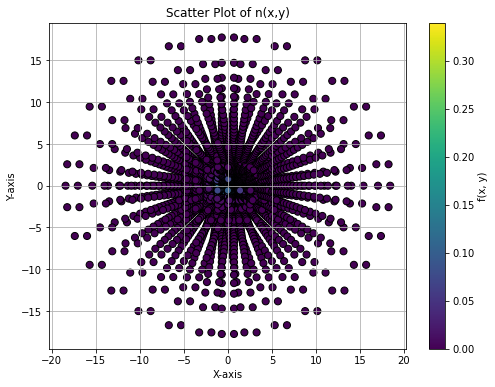

In [142]:

coords = grids.coords
newcoords=coords.T
x,y,z=newcoords
grid_size=x.shape[0]
index=[]
zarray=np.array(z)
for i in range(grid_size):
    if zarray[i]==0:
        index.append(i)

    


# Sum along the z-axis (axis=2) to project onto the xy-plane
nfa_projected = []
xz_p = []
yz_p = []
aindex=np.array(index)
for i in range(len(aindex)):
    nfap=n[(aindex[i])]
    xzp=x[(aindex[i])]
    yzp=y[(aindex[i])]
    xz_p.append(xzp)
    yz_p.append(yzp)
    nfa_projected.append(nfap)

# Plot projected V_xc on the xy-plane
plt.figure(figsize=(8, 6))
sc = plt.scatter(xz_p, yz_p, c=nfa_projected, cmap='viridis', s=50, edgecolors='k')

# Add color bar to indicate function values
plt.colorbar(sc, label="f(x, y)")

# Labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Scatter Plot of n(x,y)")

# Show plot
plt.grid(True)
plt.show()

360


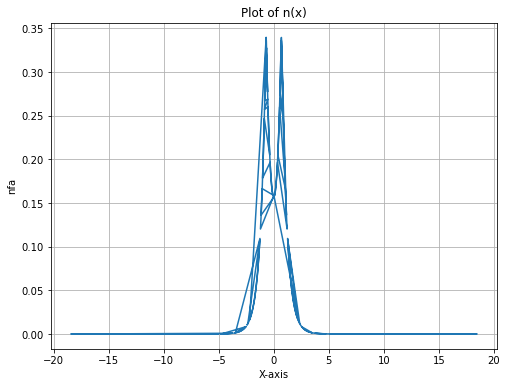

In [143]:

coords = grids.coords
newcoords=coords.T
x,y,z=newcoords
grid_size=x.shape[0]
index=[]
zarray=np.array(z)
yarray=np.array(y)
xarray=np.array(x)
for i in range(grid_size):
    if (zarray[i]==0) and (yarray[i]==0):
        index.append(i)

    


# Sum along the z-axis (axis=2) to project onto the xy-plane
nfa_projected = []
x_p = []
aindex=np.array(index)
print(len(aindex))
for i in range(len(aindex)):
    nfap=n[(aindex[i])]
    xp=x[(aindex[i])]
    x_p.append(xp)
    nfa_projected.append(nfap)

# Plot projected V_xc on the xy-plane
plt.figure(figsize=(8, 6))
plt.plot(x_p,nfa_projected)


# Labels and title
plt.xlabel("X-axis")
plt.ylabel("nfa")
plt.title("Plot of n(x)")

# Show plot
plt.grid(True)
plt.show()

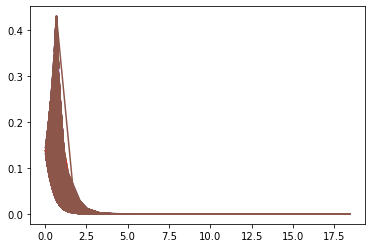

In [144]:
r=np.sqrt(xarray**2+yarray**2+zarray**2)
plt.plot(r,nfa)
plt.plot(r,nfb)
plt.plot(r,nrefa)
plt.plot(r,nrefb)
nl=D2n(Dal+Dbl,phi)
nr=D2n(Dar+Dbr,phi)
plt.plot(r,nr)
nr=D2n(Dar+Dbr,phi)
plt.plot(r,nl)

In [145]:
# Energies
(dVpa, dVpb), (Tfs, Excf, EHf) = get_dVp(Dfa, Dfb,Vext=Vext, S=S, ao_values=ao_values, w=w ) # PDFT energy from vW Ts + Eext + Vnucrepul
Eextf = np.sum(Vext * (Dfa + Dfb))
EPDFT = Tfs + EHf + Excf + Eextf
print(EPDFT)
#print(EPDFT-mydft.kernel())# compare with dft energy

-1.8860151612694298


In [146]:
(dvpain,dvpbin),(Tsin,Excin,EHin)=get_dVp(Daref, Dbref, Vext=Vext, S=S, ao_values=ao_values, w=w)

In [147]:
print(EHf)
print(EHin)

1.3174824187815757
1.3174831365034205


In [148]:
print(Tsin)
print(Tfs)

1.146091373798665
1.146083896131328


In [149]:
Eextin= np.sum((Daref+Dbref) * Vext)


In [150]:
En=mydft.energy_nuc()
print(En)

0.7194244604316548


In [151]:
Eelecin=mydft.e_tot-mydft.energy_nuc()
#Eelecin=mydft.energy_elec()[0]

In [152]:
EPDFT = Tfs + EHf + Excf + Eextf
print("energy error:", EPDFT - Eelecin)
print("Ts error:", Tfs - Tsin)
print("Eext error:", Eextf - Eextin)
print("EH error:", EHf - EHin)
print("Exc error:", Excf - Excin)

energy error: 3.1725635722956724e-06
Ts error: -7.477667337107974e-06
Eext error: 1.0372685507853419e-05
EH error: -7.177218448450873e-07
Exc error: -1.283136776719651e-06


In [153]:
print(Tsin+Eextin+EHin+Excin)

-1.886016055428979


In [154]:
print(mydft.get_veff().exc-Excin)

-5.517719614545058e-10


In [155]:
Etin= np.sum((Daref+Dbref) * T)
print(Etin-Tsin)
print(Tfs-Etin)

7.045608541034198e-11
-7.477737793193384e-06


In [156]:

# Total energy
print(f"Total energy: {mydft.e_tot} Hartree")

mydft.verbose = 0
# get_veff calculates columb energy (J) + XC, and each part is accessbile with .ecoul or .exc
# Coulomb energy (Hartree energy)
print(f"Coulomb energy: {mydft.get_veff().ecoul} Hartree")
# Exchange-correlation energy
print(f"Exchange-correlation energy: {mydft.get_veff().exc} Hartree")

# Nuclear repulsion energy
print(f"Nuclear repulsion energy: {mydft.energy_nuc()} Hartree")

# note we can also access the electronic energy with energy_elec(), which returns: (electronic energy, 2electron contribution)
print(f"Electronic energy: {mydft.energy_elec()[0]} Hartree")

Total energy: -1.1665938734013475 Hartree
Coulomb energy: 1.3174808585807134 Hartree
Exchange-correlation energy: -0.6925285978465157 Hartree
Nuclear repulsion energy: 0.7194244604316548 Hartree
Electronic energy: -1.886018333833002 Hartree
